# Recruit Restaurant Visitor Forecasting
## Background Story
- Restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members.   
- This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.


## About the Dataset
- 8 files of relational data is provided from two separate Japanes websites: "Hot Pepper Gourmet (hpg)" similar to Yelp and "AirREGI/Restairamt Board (air)" similar to Square, based on the time range of Jan 2016 - most of Apr 2017
- This restaurant data is from Japanese restaurants: we need to consider Japan's holdiay week called the "Golden Week".

## Goal
- Use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. (-> This is a Time Series Forecasting problem)

## Evaluation
- RMSLE (root mean squared logarithmic error)

## Submission
- For every store and date combination in the test set, submission files should contain two columns: `id` and `visitors`.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Feature Engineering

## 1. Load the Dataset

#### **Why 'visit_data'? (why not 'reserve_data)'**   
As we saw from the EDA, It's hard to find a strong correlation between the 'visitors' and 'hpg_reserve_data' and 'air_reserve_data'.   

#### **Why 'air_visit_data'? (why not hpg_data)**   
The common number of restaruants between AIR platform and HPG platform is only 150, which is really small number of stores. Moreover, Our sample_submission.csv tells us that we only need to predict the restaurants on AIR platform. So I dropped HPG's reserve data from the feature engineering.


So I only used the below 4 dataset to do the feature engineering + alpha with the preprocessed-version of the weather data. I will mentino this again in the (5) preprocessed weather data section.

In [ ]:
import pandas as pd
import numpy as np

data_path = '/content/drive/MyDrive/aiffel/hackaton_1_data/data/';
dest_path = '/content/drive/MyDrive/aiffel/hackaton_1_data/';

air_visit = pd.read_csv(data_path + 'air_visit_data.csv')
date_info = pd.read_csv(data_path + 'date_info.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')
air_store_info = pd.read_csv(data_path + 'air_store_info_with_nearest_active_station.csv')



In [ ]:
dest_path = '/content/drive/MyDrive/aiffel/hackaton_1_data/';


### (1) Resample the visiting data by days

#### Dealing with Time Series dataset -> resampling, rolling, shifting
 I will mainly focus on following so-called `rolling statistics` here. It is important to remember this data is **time series**, and we need to keep rolling features based on time.What this means is that I will resample the given visiting data by day so if there are no data points, the number of visits for those days be 0.    

- **Resampling**: basicallty means representing the data with a different frequency. (시간 간격을 조정)
- **Rolling**: Rolling is a very useful operation for time series data. Rolling means creating a rolling window with a specified size and perform calculations on the data in this window which, of course, rolls through the data. (임의의 시간 간격 window를 만들고, 그 안에서 통계적 aggregation을 구할 수 있다)

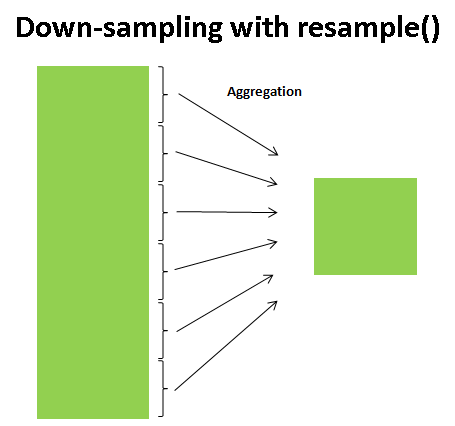

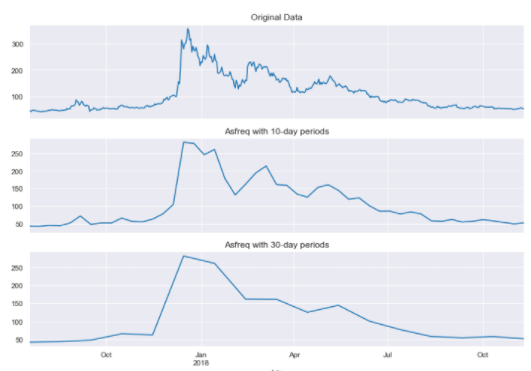

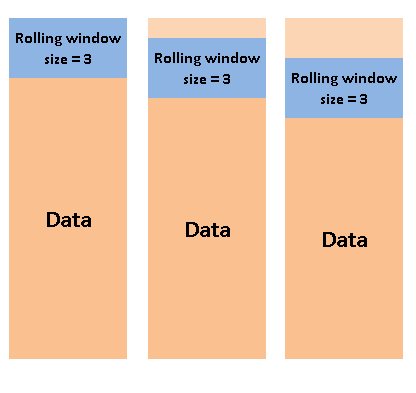

REF: https://towardsdatascience.com/time-series-analysis-resampling-shifting-and-rolling-f5664ddef77e

Here is a helper function to resample the given visiting data by day, and later I will add 0 if there are no data points. 

In [ ]:
def resample_by_visitors(group):
  return group['visitors'].resample('1d').sum() # set frequency to 1d

 Also, one more important thing is that to keep track of if the datapoint is added due to resampling, so I added the column `was_na`.

In [ ]:
air_visit.index = pd.to_datetime(air_visit['visit_date']) # convert to datetime type
air_visit = air_visit.groupby('air_store_id').apply(resample_by_visitors).reset_index()
air_visit['visit_date'] = air_visit['visit_date'].dt.strftime('%Y-%m-%d') # Use Series.dt.strftime() function to convert the dates in the given series object to the specified date format.
air_visit['was_na'] = air_visit['visitors'].isnull() # Use isna()?
air_visit['visitors'].fillna(0, inplace=True)

air_visit.head()

,air_store_id,visit_date,visitors,was_na
0,air_00a91d42b08b08d9,2016-07-01,35,False
1,air_00a91d42b08b08d9,2016-07-02,9,False
2,air_00a91d42b08b08d9,2016-07-03,0,False
3,air_00a91d42b08b08d9,2016-07-04,20,False
4,air_00a91d42b08b08d9,2016-07-05,25,False


### (2) Handle Holidays

From the calendar information, apart from the `day of the week` and `is weekend`, I will add two boolean-float attributes to indicate if the previous or the next day is holiday, since from the **EDA** we checked the calendar information matters with those holidays for the reservation rates.

In [ ]:
date_info.rename(columns={'holiday_flg': 'is_holiday', 'calendar_date': 'visit_date'}, inplace=True)
date_info['prev_day_is_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head()

,visit_date,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday
0,2016-01-01,Friday,1,0.0,1.0
1,2016-01-02,Saturday,1,1.0,1.0
2,2016-01-03,Sunday,1,1.0,0.0
3,2016-01-04,Monday,0,1.0,0.0
4,2016-01-05,Tuesday,0,0.0,0.0


### (3) Create Test Dataset

We already got some hint from the `sample_submission` file. We can extract the `store_id` and the `date` from the `id` column.    
And also I will sort the dataset in order to make sure the data has the same order with the `sample_submission`   
    
I added `is_test` column to ensure this is the test dataset. Also added `test_number` as an index and `visitors` as the results, but its `NaN` for now. 

In [ ]:
submission['air_store_id'] = submission['id'].str.slice(0, 20)
submission['visit_date'] = submission['id'].str.slice(21)
submission['is_test'] = True
submission['visitors'] = np.nan
submission['test_number'] = range(len(submission))

submission.head()

,id,visitors,air_store_id,visit_date,is_test,test_number
0,air_00a91d42b08b08d9_2017-04-23,NaN,air_00a91d42b08b08d9,2017-04-23,True,0
1,air_00a91d42b08b08d9_2017-04-24,NaN,air_00a91d42b08b08d9,2017-04-24,True,1
2,air_00a91d42b08b08d9_2017-04-25,NaN,air_00a91d42b08b08d9,2017-04-25,True,2
3,air_00a91d42b08b08d9_2017-04-26,NaN,air_00a91d42b08b08d9,2017-04-26,True,3
4,air_00a91d42b08b08d9_2017-04-27,NaN,air_00a91d42b08b08d9,2017-04-27,True,4


### (4) Format the Training set and the Test set Properly

To merge the training set and the test set, we need to format them properly.    
Let's concatenate `air_visit` and `submission`, and merge the concatenated data with `visit_date` that I created above.   

Also, Fill in the `is_test` column to False, so later we can merge the train and test and still distinguish the train and test dataset.

In [ ]:
data = pd.concat((air_visit, submission.drop('id', axis='columns')))
data['is_test'].fillna(False, inplace=True)
data = pd.merge(left=data, right=date_info, on='visit_date', how='left')
data['visitors'] = data['visitors'].astype(float)

data.head()

,air_store_id,visit_date,visitors,was_na,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0
2,air_00a91d42b08b08d9,2016-07-03,0.0,False,False,NaN,Sunday,0,0.0,0.0
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0


### (5) AIR Store data

 
As mentioned above, I only used `air_store_info` since I only care about the AIR data for the stores, not HPG stores.

In [ ]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.730672,3.739835


Then add this provided restaurants store data to the `data` dataframe by using the unique `air_store_id`.

In [ ]:
data = pd.merge(left=data, right=air_store_info, on='air_store_id', how='left')
data.head()

,air_store_id,visit_date,visitors,was_na,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
2,air_00a91d42b08b08d9,2016-07-03,0.0,False,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906


### (6) Preprocessed Weather Data

I used the preprocessed version coming from the weather data provided by a user "Hunter McGushion" https://www.kaggle.com/huntermcgushion/rrv-weather-data .   
His data is way more useful because The reason why is that the preprocessed version contains weather station data important for joining the weather features.  

Then we need to handle the other weather datasets. This data contains **1663** files (one for each of the *1663 stations* in Japan).   
This is a multi-faceted dataset that deals with time, geography, weather, and delicious food.    

And there are so many **null values** in this dataset and the reason is there are many different types of stations/sensors are used, and some just don't capture as much data as others. Also, If the station was terminated, its values are null.   


Let's load the whole dataset and see how weather is formatted.

In [ ]:
import glob

weather_dfs = []

for path in glob.glob(data_path + 'weather/1-1-16_5-31-17_Weather/*.csv'):
    weather_df = pd.read_csv(path)
    weather_df['station_id'] = path.split('\\')[-1].rstrip('.csv')
    weather_dfs.append(weather_df)

weather = pd.concat(weather_dfs, axis='rows')
weather.rename(columns={'calendar_date': 'visit_date'}, inplace=True)

weather.head()

,visit_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,station_id
0,2016-01-01,3.6,10.8,-2.0,0.0,8.5,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/aiffel/hackaton_1_data/...
1,2016-01-02,3.2,11.9,-1.7,0.0,6.2,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/aiffel/hackaton_1_data/...
2,2016-01-03,5.5,16.7,-2.2,0.0,8.4,NaN,NaN,NaN,0.9,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/aiffel/hackaton_1_data/...
3,2016-01-04,6.0,15.9,-1.3,0.0,8.5,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/aiffel/hackaton_1_data/...
4,2016-01-05,6.7,16.2,-0.7,0.0,7.3,NaN,NaN,NaN,1.1,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/aiffel/hackaton_1_data/...


To summarize,  one file for weather station. We also know each restaurant's closest weather station.   

After reading many kernels and articles about this weather data, I agreed that only **precipitation and the temperature features** are useful for this visitor analysis.    


In [ ]:
means = weather.groupby('visit_date')[['avg_temperature', 'precipitation']].mean().reset_index()
means.rename(columns={'avg_temperature': 'global_avg_temperature', 'precipitation': 'global_precipitation'}, inplace=True)
weather = pd.merge(left=weather, right=means, on='visit_date', how='left')
weather['avg_temperature'].fillna(weather['global_avg_temperature'], inplace=True)
weather['precipitation'].fillna(weather['global_precipitation'], inplace=True)

weather[['visit_date', 'avg_temperature', 'precipitation']].head()

,visit_date,avg_temperature,precipitation
0,2016-01-01,3.6,0.0
1,2016-01-02,3.2,0.0
2,2016-01-03,5.5,0.0
3,2016-01-04,6.0,0.0
4,2016-01-05,6.7,0.0


Then we can clean up the dataframe so we can extract some useful features from this!

In [ ]:
data['visit_date'] = pd.to_datetime(data['visit_date'])
data.sort_values(['air_store_id', 'visit_date'], inplace=True)

data.head()

,air_store_id,visit_date,visitors,was_na,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
2,air_00a91d42b08b08d9,2016-07-03,0.0,False,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906


Looks good. Further, I had an idea to take mean of the NN closest stations from the stores. But not sure how this will impact the model.

### (7) Genre wise restaurants grouping

Since we noticed thata number of restaurants of specific genre in a local area has a huge effect on the number of visitors, so let's group the number of restaurants with the genre per each area.   
Group by 'air_genre_name', 'air_area_name', and use `as_index` to return the count of the object with group labels as the index.   

Note that the `genre_in_area` represents the number of stores of the `genre` in that specific `area`.

In [ ]:
air_genres_area = air_store_info.copy()
air_genres_area = air_genres_area[['air_store_id', 'air_genre_name', 'air_area_name']].groupby(['air_genre_name', 'air_area_name'],
                                                                                              as_index = False).count()
air_genres_area = air_genres_area.rename(columns = {'air_store_id': 'total_stores_of_genre_in_area'})
air_genres_area.head()

,air_genre_name,air_area_name,total_stores_of_genre_in_area
0,Asian,Tōkyō-to Shibuya-ku Shibuya,2
1,Bar/Cocktail,Fukuoka-ken Fukuoka-shi Daimyō,7
2,Bar/Cocktail,Fukuoka-ken Fukuoka-shi Hakata Ekimae,2
3,Bar/Cocktail,Hiroshima-ken Hiroshima-shi Kokutaijimachi,2
4,Bar/Cocktail,Hokkaidō Asahikawa-shi 6 Jōdōri,4


### (8) Area wise restaurants grouping

Also, As we saw from the **EDA - pie chart**, there is a correlation between the **number of restaurants in the area** and **the number of visitors**.   
I can create `air_area` to group `air_store_id` with `air_area_name` and the count.

In [ ]:
# total amount of restaurants in area
air_area = air_store_info.copy()
air_area = air_area[['air_store_id', 'air_area_name']].groupby(['air_area_name'], as_index = False).count()
air_area = air_area.rename(columns = {'air_store_id': 'total_r_in_area'})

air_area.head()

,air_area_name,total_r_in_area
0,Fukuoka-ken Fukuoka-shi Daimyō,64
1,Fukuoka-ken Fukuoka-shi Hakata Ekimae,16
2,Fukuoka-ken Fukuoka-shi Imaizumi,2
3,Fukuoka-ken Fukuoka-shi Momochi,6
4,Fukuoka-ken Fukuoka-shi Shiobaru,7


As we saw from the above **EDA**, we checked the number of restaurants matter for each region, so we will add the data to the dataframe.

In [ ]:
data = pd.merge(left=data, right=air_area, on='air_area_name', how='left')
data.head()

,air_store_id,visit_date,visitors,was_na,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,total_r_in_area
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20
2,air_00a91d42b08b08d9,2016-07-03,0.0,False,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20


Okay, I see `total_r_in_ara` is added at the right-most side of the table on the `data`.

### (9) Weekends, and Day of Month

#### Why do we need this?
Then let's apply some features to see if the below features can prove what we've seen in the **EDA** above about the **day of month**. We observed that there is a constant peak on the 3rd,10th, and 22nd day of the month, and also on the **weekends**. We can see a clear pattern on them.   

To keep track of this **day of month** as a parameter, I added `is_weekend` and `day_of_month`.

In [ ]:
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
data['day_of_month'] = data['visit_date'].dt.day

In [ ]:
data['is_weekend'].head()

0    0
1    1
2    1
3    0
4    0
Name: is_weekend, dtype: int64

In [ ]:
data['day_of_month'].head()

2016-07-01    1
2016-07-02    2
2016-07-03    3
2016-07-04    4
2016-07-05    5
Name: day_of_month, dtype: int64

## 2. Preprocessing

### (1) Outliers?

Based on the EDA, the number of restaurant visits in the new year is clearly does NOT represent the rest of the year. What this means is that the outlier is a very high value. One good thing is that there is no negative values in the dataset..!

We can assume that number of visitors follow a **normal distribution** per restaurant and also define **outliers** as values ​​outside the **confidence interval.**    

The number `2.4` in the following code block is simply the **upper quantile of the normal distribution.** We recommend using `1.96` to select the top 5% of values ​​as outliers. After detecting outliers, I created a new variable called `visitors_capped` where the outliers are replaced with the maximum of the non-outliers.   

Ref: **Q**: How do you deal with outlier? **A**: Assuming that the number of visitors as a random variable with a normal distribution: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/46939

Here, I take the log_1p to store the `visitors` results.   


#### Why take log_1p?   
The reason why logarithm is important in the time series is that the curve can be used to help better identify the compound return that the visitors to the restaurants over a period of time.   
you can check the distribution of orange: normal distribution and blue: log normal distribution

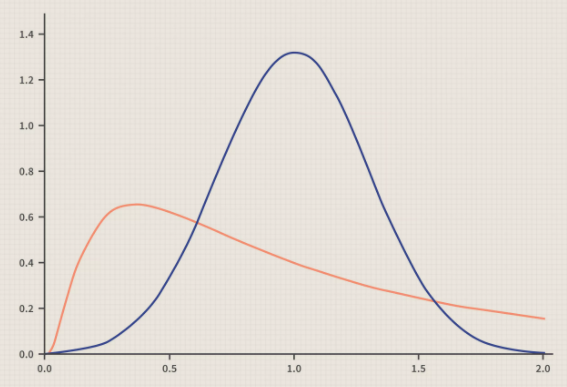

In [ ]:
def find_outliers(series):
    return (series - series.mean()) > 2.4 * series.std()


def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max() # TODO
    series[outliers] = max_val
    return series


stores = data.groupby('air_store_id')
data['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values
data['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
data['visitors_capped_log1p'] = np.log1p(data['visitors_capped'])

data.head()

,air_store_id,visit_date,visitors,was_na,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,total_r_in_area,is_weekend,day_of_month,is_outlier,visitors_capped,visitors_capped_log1p
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,1,False,35.0,3.583519
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,1,2,False,9.0,2.302585
2,air_00a91d42b08b08d9,2016-07-03,0.0,False,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,1,3,False,0.0,0.000000
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,4,False,20.0,3.044522
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,5,False,25.0,3.258097


In [ ]:
data[data["is_outlier"] == True].count()

air_store_id             4884
visit_date               4884
visitors                 4884
was_na                   4884
is_test                  4884
test_number                 0
day_of_week              4884
is_holiday               4884
prev_day_is_holiday      4884
next_day_is_holiday      4884
air_genre_name           4884
air_area_name            4884
latitude                 4884
longitude                4884
latitude_str             4884
longitude_str            4884
station_id               4884
station_latitude         4884
station_longitude        4884
station_vincenty         4884
station_great_circle     4884
total_r_in_area          4884
is_weekend               4884
day_of_month             4884
is_outlier               4884
visitors_capped          4884
visitors_capped_log1p    4884
dtype: int64

### (2) Optimization with EWM (Exponential Weighted Average)

#### What is EWM? What is the alpha value?   
**Exponential Weighted Average (EWM)** is a very good way to catch **trends** in a time series. However, they rely on the parameter alpha to model the weight of the mean. For example, if alpha is close to 1, the latest values ​​are more weighted than the previous values. Choosing an alpha is very important and there is no clear way to choose. We decided to do an optimization procedure to determine the best alpha for each store's time series by day of the week.

####  How to optimize?   
Optimization is done by differential evolution. The main reason for choosing this method is that the search space is limited between 0 and 1 (alpha region). The objective function is the mean squared error between the time series and the EWM. The EWM is computed from the time series shifted by 1 to ensure that the EWM cannot "see" the current value (otherwise it won't work on the test set). As for the test method, the values ​​for the first week and the second, third week, etc. will be the same. Of course, this is not ideal, but in my opinion there is not much you can do.

#### Ho to apply?   
One important point to note is that the following procedure was applied per store and per day of the week, but also per store and per weekend. The latter is less granular and is useful for time series where there is not much information. We also apply this procedure to restricted visitor information (previously calculated) and logs. The reason I'm doing this for the log is that it smoothes the time series and can help a little.


#### EWM란? alpha의 의미란?   
지수 가중 평균 (EWM)은 시계열의 "Trend"를 구하는데 아주 좋은 방법으로 쓰입니다. 하지만 동시에  mean weight를 모델링하는 parameter "alpha" 값에 영향을 많이 받게 됩니다. 예를 들어서, alpha 값이 1에 가까우면 , 최근 값이 그 더 이전의 값보다 더 가중치를 갖게 도비니다. 그래서 alpha를 선택하는것이 매우 중요하고, 현재는 이걸 구하는 명확한 방법이 없습니다. 그래서, 요일별로 각 restaurant의 visitors을 구하는 시계열 데이터에 가장 적합한 alpha값을 구하기 위해 최적화 절차가 필요합니다.

#### 최적화 방법은?   
최적화는 differential evolution으로 진행할 수 있습니다. 이 방법을 선택한 이유는, alpha의 도메인이 0과 1 사이인데, differential evolution을 사용한다면 search space를 0과 1 사이로 제한해줄 수 있기 때문입니다. EWM을 사용해서 time series의 Mean Square Error 를 구해줄 수 있습니다.   

#### 어떻게 적용해야 할까?   
EWM은 test method에서 작동하게 하기 위해서 현재 값을 몰라야 하기 때문에 1만큼 shift된 time series로 계산됩니다. test method에서는 1째주, 2째주, 3째주 ... 의 값이 같을 겁니다. 물론 이게 가장 이상적인 방법은 아니지만, 이 옵션 외에 더 좋은 옵션을 찾지 못했습니다..   
    
한 가지 중요한 점은, 이 과정을 restaurant별로 + 요일별로 적용하고, 또 restaurant별로 + 주말별로도 계산했다는 점입니다.    



**요약**   
이 계산은 결국 노이즈가 많은 시계열 데이터를 스무딩해줘서, 덜 자세하게 만들어서 trend를 찾기 더 쉽게 만드는 과정이라고 할 수 있습니다!   
이해를 돕기 위해 아래 그래프를 첨부하였습니다.

Exponentially weighted mean is used smoothen a time series, basically you are trying to remove noise from the series that would otherwise make the series hard to predict. 

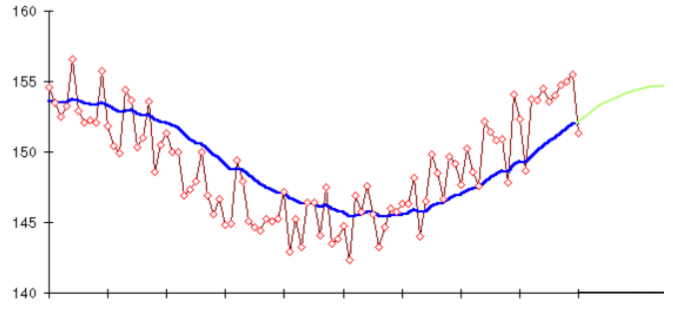

EWM: Provide exponential weighted (EW) functions.   
Ref: EWM in Time Series: https://medium.com/@parkashsharma/time-series-analysis-in-python-4f2e7a453ded

In [ ]:
from scipy import optimize


def calc_shifted_ewm(series, alpha, adjust=True):
    return series.shift().ewm(alpha=alpha, adjust=adjust).mean()


def find_best_signal(series, adjust=False, eps=10e-5):
    
    def f(alpha):
        shifted_ewm = calc_shifted_ewm(series=series, alpha=min(max(alpha, 0), 1), adjust=adjust)
        corr = np.mean(np.power(series - shifted_ewm, 2))
        return corr
     
    res = optimize.differential_evolution(func=f, bounds=[(0 + eps, 1 - eps)])
    
    return calc_shifted_ewm(series=series, alpha=res['x'][0], adjust=adjust)

In [ ]:
data.index = data['visit_date']

group the data with the `day_of_week` to optimize how Monday, Tuesday, Wednesday, ... affect the time series

In [ ]:
roll = data.groupby(['air_store_id', 'day_of_week']).apply(lambda g: find_best_signal(g['visitors_capped']))

data['optimized_ewm_by_air_store_id_&_day_of_week'] = roll.sort_index(level=['air_store_id', 'visit_date']).values


data.head()

,air_store_id,visit_date,visitors,was_na,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,total_r_in_area,is_weekend,day_of_month,is_outlier,visitors_capped,visitors_capped_log1p,optimized_ewm_by_air_store_id_&_day_of_week
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,1,False,35.0,3.583519,NaN
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,1,2,False,9.0,2.302585,NaN
2016-07-03,air_00a91d42b08b08d9,2016-07-03,0.0,False,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,1,3,False,0.0,0.000000,NaN
2016-07-04,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,4,False,20.0,3.044522,NaN
2016-07-05,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,5,False,25.0,3.258097,NaN


Also apply `is_weekend`, `day_of_week`, and take log of them.

In [ ]:
roll = data.groupby(['air_store_id', 'is_weekend']).apply(lambda g: find_best_signal(g['visitors_capped']))
data['optimized_ewm_by_air_store_id_&_is_weekend'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

roll = data.groupby(['air_store_id', 'day_of_week']).apply(lambda g: find_best_signal(g['visitors_capped_log1p']))
data['optimized_ewm_log1p_by_air_store_id_&_day_of_week'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

roll = data.groupby(['air_store_id', 'is_weekend']).apply(lambda g: find_best_signal(g['visitors_capped_log1p']))
data['optimized_ewm_log1p_by_air_store_id_&_is_weekend'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

In [ ]:
data.head()

,air_store_id,visit_date,visitors,was_na,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,total_r_in_area,is_weekend,day_of_month,is_outlier,visitors_capped,visitors_capped_log1p,optimized_ewm_by_air_store_id_&_day_of_week,optimized_ewm_by_air_store_id_&_is_weekend,optimized_ewm_log1p_by_air_store_id_&_day_of_week,optimized_ewm_log1p_by_air_store_id_&_is_weekend
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,1,False,35.0,3.583519,NaN,NaN,NaN,NaN
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,1,2,False,9.0,2.302585,NaN,NaN,NaN,NaN
2016-07-03,air_00a91d42b08b08d9,2016-07-03,0.0,False,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,1,3,False,0.0,0.000000,NaN,9.000000,NaN,2.302585
2016-07-04,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,4,False,20.0,3.044522,NaN,35.000000,NaN,3.583519
2016-07-05,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,5,False,25.0,3.258097,NaN,33.565203,NaN,3.429266


In [ ]:
data.columns.values

array(['air_store_id', 'visit_date', 'visitors', 'was_na', 'is_test',
       'test_number', 'day_of_week', 'is_holiday', 'prev_day_is_holiday',
       'next_day_is_holiday', 'air_genre_name', 'air_area_name',
       'latitude', 'longitude', 'latitude_str', 'longitude_str',
       'station_id', 'station_latitude', 'station_longitude',
       'station_vincenty', 'station_great_circle', 'total_r_in_area',
       'is_weekend', 'day_of_month', 'is_outlier', 'visitors_capped',
       'visitors_capped_log1p',
       'optimized_ewm_by_air_store_id_&_day_of_week',
       'optimized_ewm_by_air_store_id_&_is_weekend',
       'optimized_ewm_log1p_by_air_store_id_&_day_of_week',
       'optimized_ewm_log1p_by_air_store_id_&_is_weekend'], dtype=object)

Okay, now we got the optimized columns.

### (3) Additional Features with Mean, Median, Standard Deviation, Minimum, Maximum, including EWM

The distribution reflects trends describing **how far the data are from the central value**, including statistics such as maximum, minimum, standard deviation, coefficient of variation, range and interquartile range. The shape of the distribution reflects whether the distribution is symmetrical, the degree of skewness and the flatness of the distribution, including statistics such as skewness and kurtosis.   

REF: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1063-x 

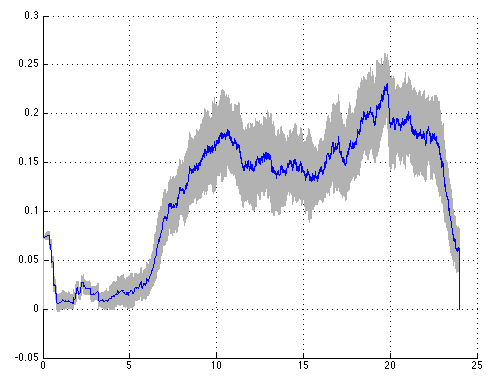

ValueError: 'visit_date' is both an index level and a column label, which is ambiguous.

In [ ]:
data.index.name = None

In [ ]:
def extract_precedent_statistics(df, on, group_by):
    
    df.sort_values(group_by + ['visit_date'], inplace=True)
    
    groups = df.groupby(group_by, sort=False)
    
    stats = {
        'mean': [],
        'median': [],
        'std': [],
        'count': [],
        'max': [],
        'min': []
    }
    
    exp_alphas = [0.1, 0.25, 0.3, 0.5, 0.75]
    stats.update({'exp_{}_mean'.format(alpha): [] for alpha in exp_alphas})
    
    for _, group in groups:
        
        shift = group[on].shift()
        roll = shift.rolling(window=len(group), min_periods=1)
        
        stats['mean'].extend(roll.mean())
        stats['median'].extend(roll.median())
        stats['std'].extend(roll.std())
        stats['count'].extend(roll.count())
        stats['max'].extend(roll.max())
        stats['min'].extend(roll.min())
        
        for alpha in exp_alphas:
            exp = shift.ewm(alpha=alpha, adjust=False)
            stats['exp_{}_mean'.format(alpha)].extend(exp.mean())
    
    suffix = '_&_'.join(group_by)
    
    for stat_name, values in stats.items():
        df['{}_{}_by_{}'.format(on, stat_name, suffix)] = values


extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id', 'day_of_week']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id', 'is_weekend']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id', 'day_of_week']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id', 'is_weekend']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id']
)

data.sort_values(['air_store_id', 'visit_date']).head()

,air_store_id,visit_date,visitors,was_na,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,total_r_in_area,is_weekend,day_of_month,is_outlier,visitors_capped,visitors_capped_log1p,optimized_ewm_by_air_store_id_&_day_of_week,optimized_ewm_by_air_store_id_&_is_weekend,optimized_ewm_log1p_by_air_store_id_&_day_of_week,optimized_ewm_log1p_by_air_store_id_&_is_weekend,visitors_capped_mean_by_air_store_id_&_day_of_week,visitors_capped_median_by_air_store_id_&_day_of_week,visitors_capped_std_by_air_store_id_&_day_of_week,visitors_capped_count_by_air_store_id_&_day_of_week,visitors_capped_max_by_air_store_id_&_day_of_week,visitors_capped_min_by_air_store_id_&_day_of_week,visitors_capped_exp_0.1_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.25_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.3_mean_by_air_store_id_&_day_of_week,...,visitors_capped_max_by_air_store_id,visitors_capped_min_by_air_store_id,visitors_capped_exp_0.1_mean_by_air_store_id,visitors_capped_exp_0.25_mean_by_air_store_id,visitors_capped_exp_0.3_mean_by_air_store_id,visitors_capped_exp_0.5_mean_by_air_store_id,visitors_capped_exp_0.75_mean_by_air_store_id,visitors_capped_log1p_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_median_by_air_store_id_&_day_of_week,visitors_capped_log1p_std_by_air_store_id_&_day_of_week,visitors_capped_log1p_count_by_air_store_id_&_day_of_week,visitors_capped_log1p_max_by_air_store_id_&_day_of_week,visitors_capped_log1p_min_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.1_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.25_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.3_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.5_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.75_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_median_by_air_store_id_&_is_weekend,visitors_capped_log1p_std_by_air_store_id_&_is_weekend,visitors_capped_log1p_count_by_air_store_id_&_is_weekend,visitors_capped_log1p_max_by_air_store_id_&_is_weekend,visitors_capped_log1p_min_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.1_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.25_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.3_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.5_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.75_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_mean_by_air_store_id,visitors_capped_log1p_median_by_air_store_id,visitors_capped_log1p_std_by_air_store_id,visitors_capped_log1p_count_by_air_store_id,visitors_capped_log1p_max_by_air_store_id,visitors_capped_log1p_min_by_air_store_id,visitors_capped_log1p_exp_0.1_mean_by_air_store_id,visitors_capped_log1p_exp_0.25_mean_by_air_store_id,visitors_capped_log1p_exp_0.3_mean_by_air_store_id,visitors_capped_log1p_exp_0.5_mean_by_air_store_id,visitors_capped_log1p_exp_0.75_mean_by_air_store_id
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,0,1,False,35.0,3.583519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,20,1,2,False,9.0,2.302585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN

### (5) Split Train and Test dataset

Things we need to do:   
- drop a few useless columns
- We predict the **log** of visitors above with EWM, and to get back to the original magnitude, we need to apply the exponential function to the prediction. **( $exp(log(x)) = x$)**

In [ ]:
data['visitors_log1p'] = np.log1p(data['visitors'])
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_na'] == False)]
test = data[data['is_test']].sort_values('test_number')

to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_na',
           'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
           'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
           'station_great_circle', 'visitors_capped_log1p']
train = train.drop(to_drop, axis='columns')
train = train.dropna()
test = test.drop(to_drop, axis='columns')

X_train = train.drop('visitors_log1p', axis='columns')
X_test = test.drop('visitors_log1p', axis='columns')
y_train = train['visitors_log1p']


In [ ]:
pd.to_datetime(train.index, format= '%Y-%m-%d')

DatetimeIndex(['2016-07-15', '2016-07-16', '2016-07-17', '2016-07-18',
               '2016-07-19', '2016-07-20', '2016-07-21', '2016-07-22',
               '2016-07-23', '2016-07-24',
               ...
               '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16',
               '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', length=280032, freq=None)

In [ ]:
train.head()

,is_holiday,prev_day_is_holiday,next_day_is_holiday,latitude,longitude,latitude_str,longitude_str,total_r_in_area,is_weekend,day_of_month,optimized_ewm_by_air_store_id_&_day_of_week,optimized_ewm_by_air_store_id_&_is_weekend,optimized_ewm_log1p_by_air_store_id_&_day_of_week,optimized_ewm_log1p_by_air_store_id_&_is_weekend,visitors_capped_mean_by_air_store_id_&_day_of_week,visitors_capped_median_by_air_store_id_&_day_of_week,visitors_capped_std_by_air_store_id_&_day_of_week,visitors_capped_count_by_air_store_id_&_day_of_week,visitors_capped_max_by_air_store_id_&_day_of_week,visitors_capped_min_by_air_store_id_&_day_of_week,visitors_capped_exp_0.1_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.25_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.3_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.5_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.75_mean_by_air_store_id_&_day_of_week,visitors_capped_mean_by_air_store_id_&_is_weekend,visitors_capped_median_by_air_store_id_&_is_weekend,visitors_capped_std_by_air_store_id_&_is_weekend,visitors_capped_count_by_air_store_id_&_is_weekend,visitors_capped_max_by_air_store_id_&_is_weekend,visitors_capped_min_by_air_store_id_&_is_weekend,visitors_capped_exp_0.1_mean_by_air_store_id_&_is_weekend,visitors_capped_exp_0.25_mean_by_air_store_id_&_is_weekend,visitors_capped_exp_0.3_mean_by_air_store_id_&_is_weekend,visitors_capped_exp_0.5_mean_by_air_store_id_&_is_weekend,visitors_capped_exp_0.75_mean_by_air_store_id_&_is_weekend,visitors_capped_mean_by_air_store_id,visitors_capped_median_by_air_store_id,visitors_capped_std_by_air_store_id,visitors_capped_count_by_air_store_id,...,visitors_capped_log1p_max_by_air_store_id_&_is_weekend,visitors_capped_log1p_min_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.1_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.25_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.3_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.5_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.75_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_mean_by_air_store_id,visitors_capped_log1p_median_by_air_store_id,visitors_capped_log1p_std_by_air_store_id,visitors_capped_log1p_count_by_air_store_id,visitors_capped_log1p_max_by_air_store_id,visitors_capped_log1p_min_by_air_store_id,visitors_capped_log1p_exp_0.1_mean_by_air_store_id,visitors_capped_log1p_exp_0.25_mean_by_air_store_id,visitors_capped_log1p_exp_0.3_mean_by_air_store_id,visitors_capped_log1p_exp_0.5_mean_by_air_store_id,visitors_capped_log1p_exp_0.75_mean_by_air_store_id,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food,visitors_log1p
2016-07-15,0,0.0,0.0,35.694003,139.753595,"""35.6940027""","""139.7535951""",20,0,15,35.000700,31.809886,3.587512,3.425805,38.5,38.5,4.949747,2.0,42.0,35.0,35.7,36.75,37.1,38.5,40.25,29.800000,28.5,6.762642,10.0,42.0,20.0,31.727359,30.354221,30.199542,29.837891,29.322735,22.714286,25.0,13.216706,14.0,...,3.761200,3.044522,3.472641,3.428922,3.424899,3.417702,3.406028,2.774754,3.258097,1.244123,14.0,3.7612,0.0,3.031330,3.041087,3.091142,3.286497,3.394307,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.367296
2016-07-16,0,0.0,0.0,35.694003,139.753595,"""35.6940027""","""139.7535951""",20,1,16,9.060734,8.699862,2.302603,2.006346,10.0,10.0,1.414214,2.0,11.0,9.0,9.2,9.50,9.6,10.0,10.50,5.000000,4.5,5.830952,4.0,11.0,0.0,7.551000,5.859375,5.397000,3.875000,2.203125,23.066667,25.0,12.808851,15.0,...,2.484907,0.000

### (6) Validation Set

Though I did not use this in the end, but at first, I tried to grab the validation set by devide the dataset based on the date 2017/3/30.   
But later, I decided to use **KFold** model selection method.    

The code is located in the section "Model - Train & Validaion" below.

In [ ]:
# getting train & validation indexes
train_index = train.loc[pd.to_datetime(train.index, format= '%Y-%m-%d') <= pd.to_datetime('2017-03-30',format= '%Y-%m-%d')].index
val_index = train.loc[pd.to_datetime(train.index, format= '%Y-%m-%d') > pd.to_datetime('2017-03-30',format= '%Y-%m-%d')].index
y = train['visitors_log1p'].values

In [ ]:
X_train.head()

,is_holiday,prev_day_is_holiday,next_day_is_holiday,latitude,longitude,latitude_str,longitude_str,total_r_in_area,is_weekend,day_of_month,optimized_ewm_by_air_store_id_&_day_of_week,optimized_ewm_by_air_store_id_&_is_weekend,optimized_ewm_log1p_by_air_store_id_&_day_of_week,optimized_ewm_log1p_by_air_store_id_&_is_weekend,visitors_capped_mean_by_air_store_id_&_day_of_week,visitors_capped_median_by_air_store_id_&_day_of_week,visitors_capped_std_by_air_store_id_&_day_of_week,visitors_capped_count_by_air_store_id_&_day_of_week,visitors_capped_max_by_air_store_id_&_day_of_week,visitors_capped_min_by_air_store_id_&_day_of_week,visitors_capped_exp_0.1_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.25_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.3_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.5_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.75_mean_by_air_store_id_&_day_of_week,visitors_capped_mean_by_air_store_id_&_is_weekend,visitors_capped_median_by_air_store_id_&_is_weekend,visitors_capped_std_by_air_store_id_&_is_weekend,visitors_capped_count_by_air_store_id_&_is_weekend,visitors_capped_max_by_air_store_id_&_is_weekend,visitors_capped_min_by_air_store_id_&_is_weekend,visitors_capped_exp_0.1_mean_by_air_store_id_&_is_weekend,visitors_capped_exp_0.25_mean_by_air_store_id_&_is_weekend,visitors_capped_exp_0.3_mean_by_air_store_id_&_is_weekend,visitors_capped_exp_0.5_mean_by_air_store_id_&_is_weekend,visitors_capped_exp_0.75_mean_by_air_store_id_&_is_weekend,visitors_capped_mean_by_air_store_id,visitors_capped_median_by_air_store_id,visitors_capped_std_by_air_store_id,visitors_capped_count_by_air_store_id,...,visitors_capped_log1p_count_by_air_store_id_&_is_weekend,visitors_capped_log1p_max_by_air_store_id_&_is_weekend,visitors_capped_log1p_min_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.1_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.25_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.3_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.5_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.75_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_mean_by_air_store_id,visitors_capped_log1p_median_by_air_store_id,visitors_capped_log1p_std_by_air_store_id,visitors_capped_log1p_count_by_air_store_id,visitors_capped_log1p_max_by_air_store_id,visitors_capped_log1p_min_by_air_store_id,visitors_capped_log1p_exp_0.1_mean_by_air_store_id,visitors_capped_log1p_exp_0.25_mean_by_air_store_id,visitors_capped_log1p_exp_0.3_mean_by_air_store_id,visitors_capped_log1p_exp_0.5_mean_by_air_store_id,visitors_capped_log1p_exp_0.75_mean_by_air_store_id,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
2016-07-15,0,0.0,0.0,35.694003,139.753595,"""35.6940027""","""139.7535951""",20,0,15,35.000700,31.809886,3.587512,3.425805,38.5,38.5,4.949747,2.0,42.0,35.0,35.7,36.75,37.1,38.5,40.25,29.800000,28.5,6.762642,10.0,42.0,20.0,31.727359,30.354221,30.199542,29.837891,29.322735,22.714286,25.0,13.216706,14.0,...,10.0,3.761200,3.044522,3.472641,3.428922,3.424899,3.417702,3.406028,2.774754,3.258097,1.244123,14.0,3.7612,0.0,3.031330,3.041087,3.091142,3.286497,3.394307,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-07-16,0,0.0,0.0,35.694003,139.753595,"""35.6940027""","""139.7535951""",20,1,16,9.060734,8.699862,2.302603,2.006346,10.0,10.0,1.414214,2.0,11.0,9.0,9.2,9.50,9.6,10.0,10.50,5.000000,4.5,5.830952,4.0,11.0,0.0,7.551000,5.859375,5.397000,3.875000,2.203125,23.066667,

In [ ]:
X_train.index

DatetimeIndex(['2016-07-15', '2016-07-16', '2016-07-17', '2016-07-18',
               '2016-07-19', '2016-07-20', '2016-07-21', '2016-07-22',
               '2016-07-23', '2016-07-24',
               ...
               '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16',
               '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', length=280032, freq=None)

In [ ]:
sum(test[test["visitors_log1p"] == np.nan].count())

0

In [ ]:
assert X_train.isnull().sum().sum() == 0
assert y_train.isnull().sum() == 0
assert len(X_train) == len(y_train)
assert X_test.isnull().sum().sum() == 0
assert len(X_test) == 32019

In [ ]:
print(X_train.isnull().sum().sum())
print(y_train.isnull().sum())
print()

0
0



### Handle Categorical variables

There are many ways to handle categorical variables, and I tried 2 methods that are most widely used: **One-hot encodiing** and **Label encoding**   

#### When to use a Label Encoding vs. One Hot Encoding
- One-Hot Encoding when:
  - The categorical feature is not ordinal 
  - The number of categorical features is less so one-hot encoding can be effectively applied

- Label Encoding when:
  - The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
  - The number of categories is quite large as one-hot encoding can lead to high memory consumption


REF: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

### (7) One - Hot Encoding

Also Let's apply one-hot encode those **categorical variables**: ['day_of_week', 'air_genre_name' using **get_dummies** function.

In [ ]:
data = pd.get_dummies(data, columns=['day_of_week', 'air_genre_name'])


### (8) Label encoding categorial features

Tried this label encoding, but did not include them on the dataset

In [ ]:
from sklearn import preprocessing

train_opt = train.copy()
test_opt = test.copy()
text_columns = []
# label encoding categorical features
for f in train_opt.columns:
    if (train_opt[f].dtype == 'object'):  
        text_columns.append(f)            
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_opt[f].values) + list(test_opt[f].values))
        train_opt[f] = lbl.transform(list(train_opt[f].values))
        test_opt[f] = lbl.transform(list(test_opt[f].values))

Finally! We can generate the validation dataset.   
Personally, this was the hardest part overall.    

I found an important fact about `.iloc` and `.loc`: From Pandas documentation on `.iloc`:   
Pandas provides a suite of methods in order to get purely integer based indexing. The semantics follow closely python and numpy slicing. **These are 0-based indexing.**

In [ ]:
# Took too much time to grab the validation set... decided to skip this process
# validation data
val_train = train_opt.iloc[train_index]
val_train_y = y[train_index]
val_test = train_opt.iloc[val_index]
val_test_y = y[val_index]

val_train.to_csv(dest_path + 'val_train.csv',index=False)
val_test.to_csv(dest_path + 'val_test.csv',index=False)
np.save(dest_path + 'val_train_y.npy',val_train_y)
np.save(dest_path + 'val_test_y.npy',val_test_y)

### (9) Feature Importance

Check feature importance with XGBregressor

In [ ]:
# ValueError: DataFrame.dtypes for data must be int, float or bool.
#                Did not expect the data types in fields latitude_str, longitude_str
to_drop = ['latitude_str', 'longitude_str']

X_train = X_train.drop(to_drop, axis='columns')
X_test= X_test.drop(to_drop, axis='columns')

In [ ]:
import xgboost as xgb

# model
model = xgb.XGBRegressor()

model.fit(X=X_train, y = y_train)

[14:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
feature_importances.sort_values(0, ascending=False)


In [ ]:
plt.figure(figsize=(15,12))
plt.title('Feature Importances (Top 20 features)')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')

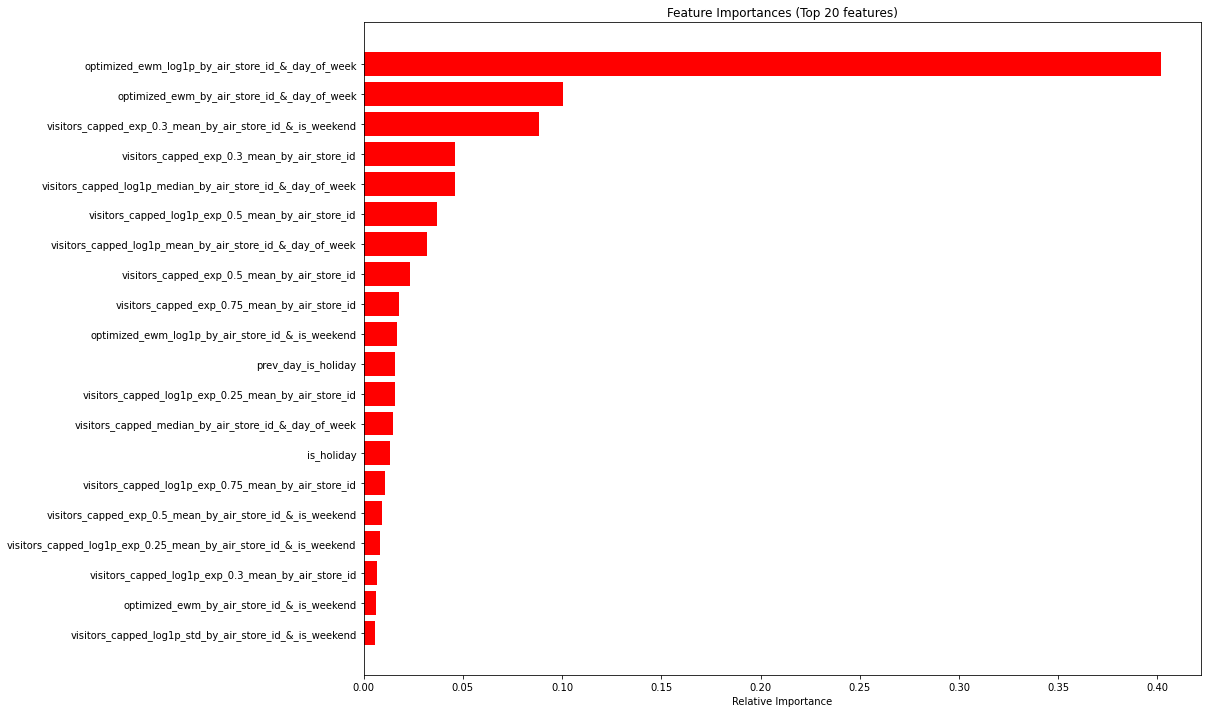

In [ ]:
import matplotlib.pyplot as plt

features = X_train_2.columns
importances = model.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(15,12))
plt.title('Feature Importances (Top 20 features)')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###  (10) Feature Selection using Recursive Feature Elimination

We can find out optimal number of features to be selected using Recursive Feature Elimination Cross-Validation    
Feature selection is an important task for any machine learning application, and since we have a lot of features, we can reduce the number of features with this.


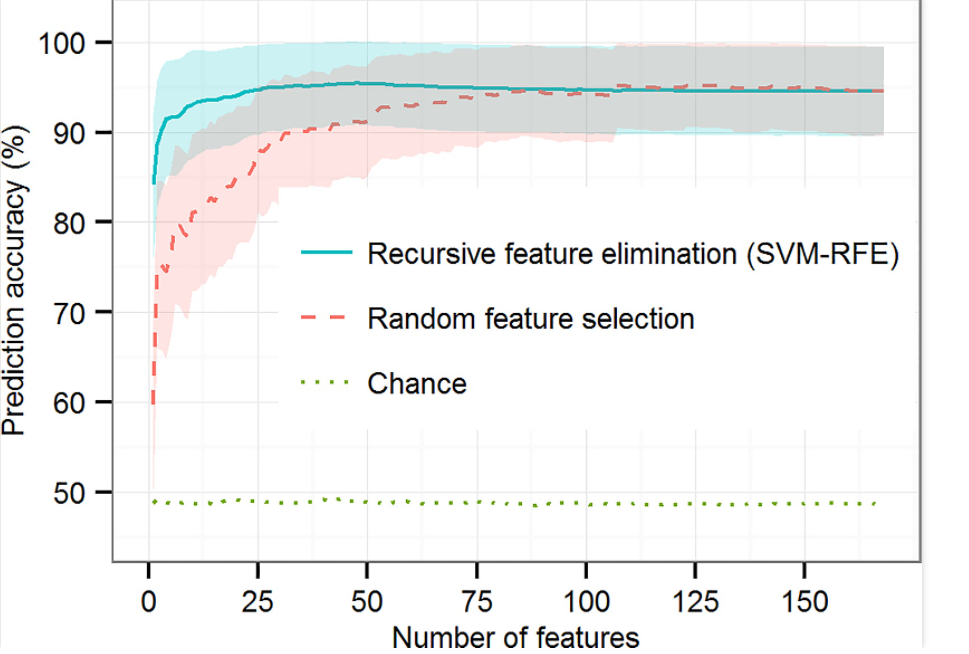

From the above picture, accuracy is shown for classifiers based on recursive feature elimination (solid blue line), random feature selection (dashed red line), and chance (dotted green line).  Shaded regions indicate mean ± 1 standard deviation over the 100 repetitions.   
REF: https://plos.figshare.com/articles/figure/Prediction_accuracy_as_a_function_of_the_numbers_of_features_selected_during_training_/4301102

I wondered what to choose between RFE and RFS (Random Feature Selection), but by looking at the graph, I think RFE will do the job here.

In [ ]:
# X_fit = X_train.iloc[model_s[0][0]]
# y_fit = y_train.iloc[model_s[0][0]]
# X_val = X_train.iloc[model_s[0][1]]
# y_val = y_train.iloc[model_s[0][1]]

In [ ]:
# setting up Recursive Feature Eliminator with n_features_to_select=61
rfe = RFE(estimator=model, n_features_to_select=80)
rfe.fit(X_train,y_train)
print("Selected Columns and their respective ranks:-\n\n")
for i,j in enumerate(X_train.columns):
    if rfe.support_[i]:
        print('Column Name: {}, Rank: {}'.format(j, rfe.ranking_[i]))
    else:
        X_train.drop(columns=j,inplace=True)
        X_test.drop(columns=j,inplace=True)
        X_val.drop(columns=j,inplace=True)

Selected Columns and their respective ranks:-


Column Name: is_holiday, Rank: 1
Column Name: latitude, Rank: 1
Column Name: longitude, Rank: 1
Column Name: day_of_month, Rank: 1
Column Name: optimized_ewm_by_air_store_id_&_day_of_week, Rank: 1
Column Name: optimized_ewm_by_air_store_id_&_is_weekend, Rank: 1
Column Name: optimized_ewm_log1p_by_air_store_id_&_day_of_week, Rank: 1
Column Name: optimized_ewm_log1p_by_air_store_id_&_is_weekend, Rank: 1
Column Name: visitors_capped_std_by_air_store_id_&_day_of_week, Rank: 1
Column Name: visitors_capped_exp_0.1_mean_by_air_store_id_&_day_of_week, Rank: 1
Column Name: visitors_capped_exp_0.3_mean_by_air_store_id_&_day_of_week, Rank: 1
Column Name: visitors_capped_exp_0.75_mean_by_air_store_id_&_day_of_week, Rank: 1
Column Name: visitors_capped_mean_by_air_store_id_&_is_weekend, Rank: 1
Column Name: visitors_capped_std_by_air_store_id_&_is_weekend, Rank: 1
Column Name: visitors_capped_count_by_air_store_id_&_is_weekend, Rank: 1
Column Name: vi

In [ ]:
X_train.shape, y_train.shape

((280032, 40), (280032,))

In [ ]:
X_test.shape

(32019, 40)

In [ ]:

# SAVING PROCESSED DATA AFTER RFE
X_train.to_csv(dest_path + 'X_train_after_RFE.csv',index=False)
X_val.to_csv(dest_path + 'X_val_after_RFE.csv',index=False)
X_test.to_csv(dest_path + 'X_test_after_RFE.csv',index=False)

### Summary of Feature Engineering

1. Apply the concept of '**resampling**' and '**rolling features**'
2. Handle Holidays & Weekend spike
3. Merge Train & Test (Submission) dataset by adding a column `is_test`
4. Merged `Air_store data, Air_visit data, date_info, and preprocessed weather data`
5. Grouping **genre-wise** and **area-wise** restaurants
6. Take care of **weekdays** and **day of month**
7. Tried multiple ways to create Validation set
8. Handle Categorical variables by trying **one-hot encoding** & **label encoding**
9. Visualize **Feature Importance**
10. Tried Feature Selection with **RFE (Recursive Feature Elimination)**

11. Handled outliers with taking log_1p
12. Optimization with **EWM (Exponential Weighted Average)**
13. Compute additional features with **mean, mediam, standard deviation, min, max**


# Model

## 1. Train & Validation

I will take the validation dataset from the train dataset using `KFold`. By using the `KFold`, I can shuffle the dataset and grab a partial data with the `random_state`.   

The label distribution of the dataset in each fold follows the label distribution of the entire dataset.

In other words, each fold is a good representation of the entire dataset, the model can be trained without bias.

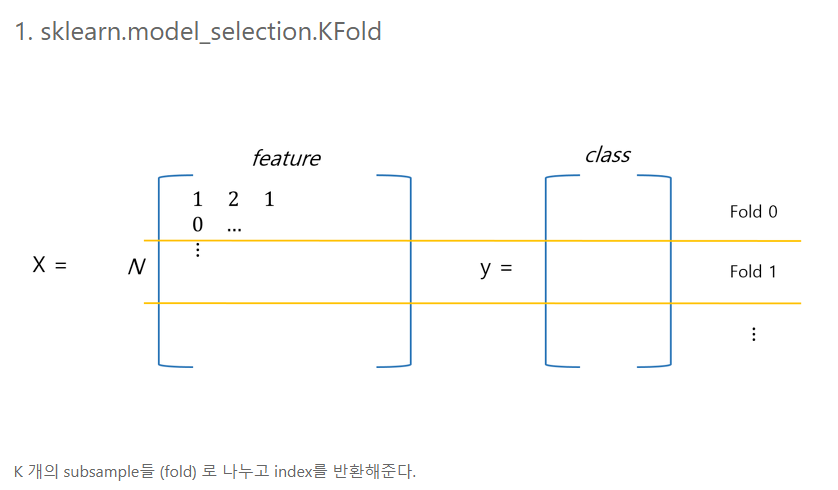

You may think that KFold is not appropriate for time series data, since KFold divides the data into multiple datasets.    

#### However, we can do the KFold validation on a rolling basis.   

We can forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.

REF: https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

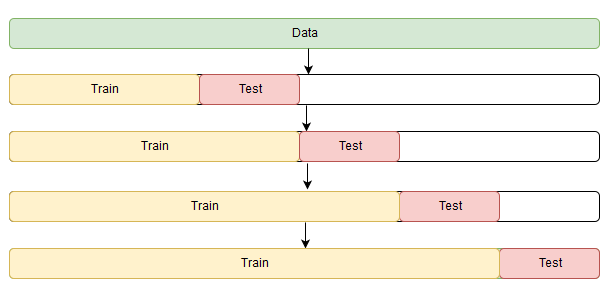

In [ ]:
from sklearn import model_selection

cv = model_selection.KFold(n_splits=6, shuffle=True, random_state=42)
tmp = cv.split(X_train, y_train)
type(tmp)
model_s = list(tmp)
type(model_s)

res = submission['id'].to_frame()
res['visitors'] = 0


# validation dataset
X_fit = X_train.iloc[model_s[0][0]]
y_fit = y_train.iloc[model_s[0][0]]
X_val = X_train.iloc[model_s[0][1]]
y_val = y_train.iloc[model_s[0][1]]


Ref: https://sgmath.tistory.com/61

#### Lessons I learned here: Important, but easy to forget!
Since we are using `.iloc`, we need to careful about we want the return value as **dataframe, NOT a series**.  
I made a mistake on this and spent a good amount of time to see why the `.iloc` is returning only a single row of the data.

In [ ]:
type(X_train_2)

pandas.core.frame.DataFrame

### 2. Create Model

### LGBM

조정 전: 15분   
조정 후: 10초   
score와 RMSLE결과값은 차이가 없었음.

In [ ]:
import lightgbm as lgbm

model = lgbm.LGBMRegressor(
    objective='regression',
    max_depth=5,
    num_leaves=5 ** 2 - 1,
    learning_rate=0.2, # 조정 0.002 -> 0.2
    n_estimators=300, # 조정 300000 -> 300
    min_child_samples=80,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=np.random.randint(10e6)
)

model.fit(X_fit, y_fit, eval_set=[(X_fit, y_fit), (X_val, y_val)], eval_names=('fit', 'val'), eval_metric='l2', early_stopping_rounds=200, feature_name=X_fit.columns.tolist(), verbose=False
)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              importance_type='split', learning_rate=0.2, max_depth=5,
              min_child_samples=80, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=24,
              objective='regression', random_state=2234489, reg_alpha=0,
              reg_lambda=0, silent=True, subsample=0.8,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
type(X_fit)

pandas.core.frame.DataFrame

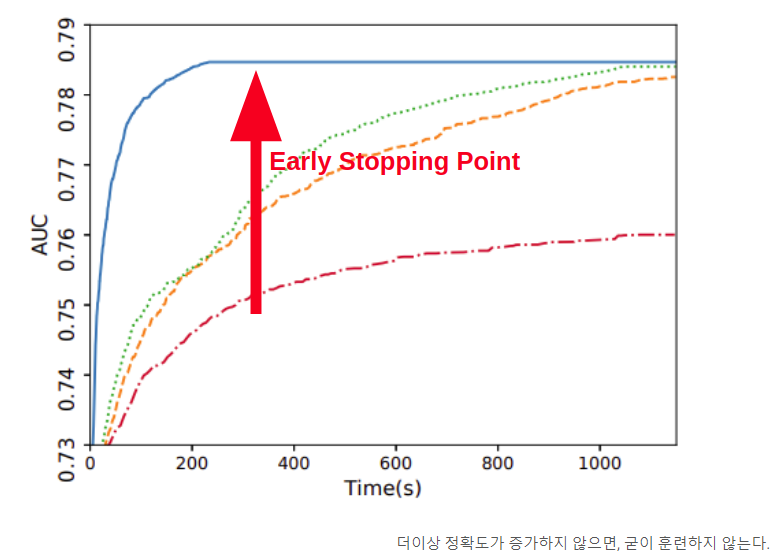

초반에 LGBM을 돌렸을 때, learning rate가 너무 낮아서 한번, early stopping point에 도달해서 모델이 두번 멈췄음.

REF: http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/ 

Result 1: First attempt with no RFE

In [ ]:
score = np.sqrt(model.best_score_['val']['l2']) # "12" means the default lgbm
res['visitors'] = model.predict(X_test, num_iteration=model.best_iteration_)
feature_importance = model.feature_importances_
print("RMLSE: ", score)

RMLSE:  0.7105582145767655


Result 2: Second attempt with REF 61

In [ ]:
score = np.sqrt(model.best_score_['val']['l2']) 
res['visitors'] = model.predict(X_test, num_iteration=model.best_iteration_)
feature_importance = model.feature_importances_
print("RMLSE: ", score)

RMLSE:  0.7145042415471411


Result 3: Second attempt with REF 40

In [ ]:
score = np.sqrt(model.best_score_['val']['l2']) 
res['visitors'] = model.predict(X_test, num_iteration=model.best_iteration_)
feature_importance = model.feature_importances_
print("RMLSE: ", score)

RMLSE:  0.7174194777064974


The score is getting higher...    
I think at this point I nned to try ensemble.

Export the result to a CSV file.

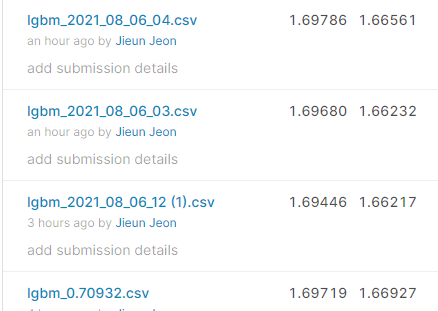

The score is way too high.
I will re-do the feature selection, then try other models if necessary.

In [ ]:
res.to_csv(dest_path + '/lgbm_2021_08_06_04.csv', index=False)


### Ensemble

The multiple attemps with RFE did not improve the score.   
Now let's try ensembling multiple models with  GradientBoostingRegressor, KNeighborsRegressor, and XGBRegressor.

In [ ]:
from sklearn import neighbors 
from xgboost import XGBRegressor
from sklearn import ensemble

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5
    
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12)
#  X_fit, y_fit,
model1.fit(X_fit, y_fit,)
model2.fit(X_fit, y_fit,)
model3.fit(X_fit, y_fit,)

preds1 = model1.predict(X_fit)
preds2 = model2.predict(X_fit)
preds3 = model3.predict(X_fit)

print('RMSE GradientBoostingRegressor: ', RMSLE(y_fit, preds1))
print('RMSE KNeighborsRegressor: ', RMSLE(y_fit, preds2))
print('RMSE XGBRegressor: ', RMSLE(y_fit, preds3))

RMSE GradientBoostingRegressor:  0.4461286853261683 
RMSE KNeighborsRegressor:  0.6400569702970031 
RMSE XGBRegressor:  0.2621902068998613


Attempt 4: Ensemble with GradientBoostingRegressor, KNeighborsRegressor, and XGBRegressor

In [ ]:
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
preds3 = model3.predict(X_test)

res['visitors'] = 0.3*preds1 + 0.3 * preds2 + 0.4*preds3
res['visitors'] = np.expm1(res['visitors']).clip(lower=0.)
sub1 = res[['id','visitors']].copy()
# del train; del data;

#### Bagging
Gradient Boosting Regressor

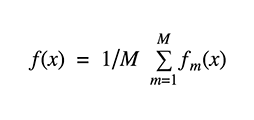

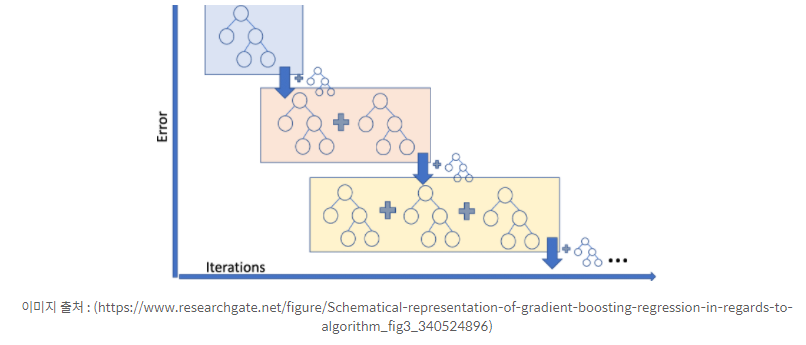

REF: https://biology-statistics-programming.tistory.com/49

In [ ]:
sub1.to_csv(dest_path + '/lgbm_2021_08_06_04_ensemble.csv', index=False)


## Result

Finally! We got the score of 0.58640

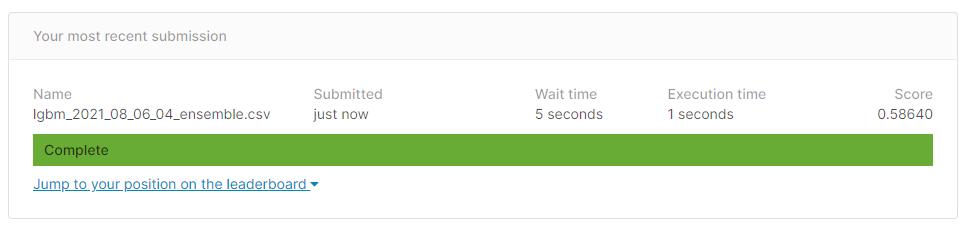

Now I can proudly say, ensemble is the game-changer.    


# References

Kernels
- Max HalFold: https://github.com/MaxHalford/kaggle-recruit-restaurant/blob/master/Solution.ipynb
- Got an idea of ensemble models: https://www.kaggle.com/tunguz/surprise-me-2
- Got an idea merging data with the mean values: https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
- Got an insight of **Feature Engineering**: https://github.com/ligz08/Kaggle-Recruit-Restaurant-Visitor-Forecasting/blob/master/Feature_Engineering.ipynb 

Disucssion
- Externel weather dataset: https://www.kaggle.com/huntermcgushion/rrv-weather-data
- Q: How do you deal with outlier? A: Assuming that the number of visitors as a random variable with a normal distribution: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/46939

Articles
- EWM: https://stackoverflow.com/questions/64575336/ewm-in-pandas-for-timeseries-transformation 
- Ideas of possible approaches: https://medium.com/analytics-vidhya/recruit-restaurant-visitor-forecasting-f9ef87ba1073